### PyKGML: Quick Start Example
This notebook demonstrates the use of [**PyKGML**](https://github.com/AI4Agriculture/PyKGML_development), a Python libaray for efficient knowledge-guided machine learning (KGML) development. 

In this example, we will demonstrate how develop a KGML model to predict CO<sub>2</sub> fluxes. The modeling steps include:   
- Pretraining a pure machine learning model using synthetic data.  
- Designing a knowledge-guided model architecture.  
- Customizing a loss function.  
- Fine-tuning the pretrained model using field observations.  


### Step 1: import libraries and classes

1. Required Python libraries:  
- **torch**: The main PyTorch library for deep learning.
- **torch.nn**: the torch neural network mudule.
- **dataLoader**: an efficient utility that handle data batching, shuffling, and parallel loading.

2. PyKGML functions/classes  
- **time_series_models**: this file stores pre-defined neural network algorithms and tools.  
    The the current gallery, users can select one model among:  
    - **GRUSeq2Seq**: a Gated Recurrent Unit (GRU) model.

    - **LSTMSeq2Seq**: a Long Short-Term Memory (LSTM) model.

    - **1dCNN**: 1D convolutional neural networks (CNN) model.

    - **Attention**: a self-attention model.

    - **TimeSeriesTransformer**: an transformer encoder model.

    - **GRUSeq2SeqWithAttention**: a GRU + self-attention model.

    - **N2OGRU_KGML**: This is a simplified version of KGMLag-N2O model structure from [Liu et al., 2022](https://doi.org/10.5194/gmd-15-2839-2022)
    - **RecoGRU_KGML**: This is the simplified version of KGMLag-CO2 model structure from [Liu et al., 2024](https://www.nature.com/articles/s41467-023-43860-5)  

- **SequenceDataset**: this is a class that help prepares the data as samples with a specified sequence length and stores them along with the corresponding labels.  
It works with PyTorch’s **DataLoader** to create an iterable to enable easy access to the samples.

- **kgml_lib**: This is a library where utility functions are defined and stored:
    - Z_norm, Z_norm_with_scaler: normalization. 

    - Z_norm_reverse: reverse normalization. 

    - LossFunctionCompiler: a compiler for loss function design.

    - ModelStructureCompiler: a compiler for model structure design.
    
    - plot_features: a function for plotting features.

In [15]:
# Import Python libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import classes/functions from the PyKGML
from time_series_models import GRUSeq2SeqWithAttention, SequenceDataset
from dataset import plot_features
import kgml_lib

### Step 2: dataset loading  

1. Dataset  

    Two example datasets were used in this toturial:  
    - co2_pretrain_data: synthetic data for model pretraining.  
    - co2_finetune_data: field observation data for fine-tuning. 
    <br />
    
    The dataset was saved as a disctionary that looks like this:  
    <pre>   
        co2_pretrain_data = {'X_train': X_train,  
                            'X_test': X_test,  
                            'Y_train': Y_train,  
                            'Y_test': Y_test,  
                            'x_scaler': x_scaler, 
                            'y_scaler': y_scaler,  
                            'input_features': input_features,  
                            'output_features': output_features}   
        </pre>
    Values in the dataset dictionary and their dimensions are:  
    - X_train: input data for training, [samples, sequences, features].  
    - X_test: input data for testing, [samples, sequences, features].  
    - Y_train: output data for training, [samples, sequences, features].  
    - Y_test: output data for testing, [samples, sequences, features].  
    - x_scaler: the scaler used to normalize the input data, [features, [mean, std]].  
    - y_scaler: the scaler used to normalize the output data, [features, [mean, std]].  
    - input_features: a list of input feature names.  
    - output_features: a list of output feature names.  

<br>

2. Loading method   

    Torch.load() is used to load the example data files, 'co2_pretrain_data.sav' and 'co2_finetune_data.sav'.  

<br>

3. Descriptions of the dataset
    - co2_pretrain_data:  
        - 100 samples (100 sites)
        - Each sample is a daily sequence over 18 years (6570) 
        - 19 input_features and 3 output_features 
        - Data split: 80 samples in the training set and 20 samples in the testing set.

        Input features (19):
        - Meterological (7): solar radiation (RADN), max air T (TMAX_AIR), (max-min) air T (TDIF_AIR), max air humidity (HMAX_AIR), (max-min) air humidity (HDIF_AIR), wind speed (WIND), precipitation (PRECN).
        - Soil properties (9): bulk density (TBKDS), sand content (TSAND), silt content (TSILT), field capacity (TFC), wilting point (TWP), saturate hydraulic conductivity (TKSat), soil organic carbon concetration (TSOC), pH (TPH), cation exchange capacity (TCEC)
        - Other (3): year (Year), crop type (Crop_Type), gross primary productivity (GPP)

       Output features (3):
        - Autotrophic respiration (Ra), heterotrophic respiration (Rh), net ecosystem exchange (NEE). 
          
    - co2_finetune_data:  
        - One sample (11 sites were concatnated into one sequence due to varied sequence lengths)
        - A Daily sequence of total 124 site-years (45260 in length)
        - 19 input_features and 2 output_features  
        - Data split: the last 2 years from each site were combined as the testing set and the rest were set as the training set.

        Input features (19):
        - The same as co2_pretrain_data.  
       
        Output features (2):
        - Ecosystem respiration (Reco, Reco = Ra + Rh), net ecosystem exchange (NEE). 
    
    Features are the same in the two datasets, except that co2_finetune_data does not have Ra and Rh directly but have Reco, which is the combination of Ra and Rh. Reco and NEE of co2_finetune_data in Y_train and Y_test are not standardized so co2_finetune_data has no y_scaler.

In [16]:
# Load dataset
data_path = '/Users/yufengyang/Documents/GitHub/data/PyKGML/'
output_path = data_path + 'test_results/CO2/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

pretrain_file = data_path + 'co2_pretrain_data.sav'
pretrain_data = torch.load(pretrain_file, weights_only=False)
finetune_file = data_path + 'co2_finetune_data.sav'
finetune_data = torch.load(finetune_file, weights_only=False)
print(pretrain_data.keys())
print(finetune_data.keys())

dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'x_scaler', 'y_scaler', 'input_features', 'output_features'])
dict_keys(['X_train', 'X_test', 'Y_train', 'Y_test', 'x_scaler', 'input_features', 'output_features'])


In [17]:
# Assign training and testing data. 
X_train, X_test, Y_train, Y_test = pretrain_data['X_train'], pretrain_data['X_test'], pretrain_data['Y_train'], pretrain_data['Y_test']
# y_scaler contains the means and stds. To reverse Y data to the original, use kgml.lib.Z_norm_reverse
x_scaler = pretrain_data['x_scaler']
y_scaler = pretrain_data['y_scaler']
input_features = pretrain_data['input_features']
output_features = pretrain_data['output_features']

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print(x_scaler.shape, y_scaler.shape)
print(input_features, output_features)

torch.Size([20, 6570, 19]) torch.Size([20, 6570, 3]) torch.Size([80, 6570, 19]) torch.Size([80, 6570, 3])
(19, 2) (3, 2)
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC'] ['Ra', 'Rh', 'NEE']


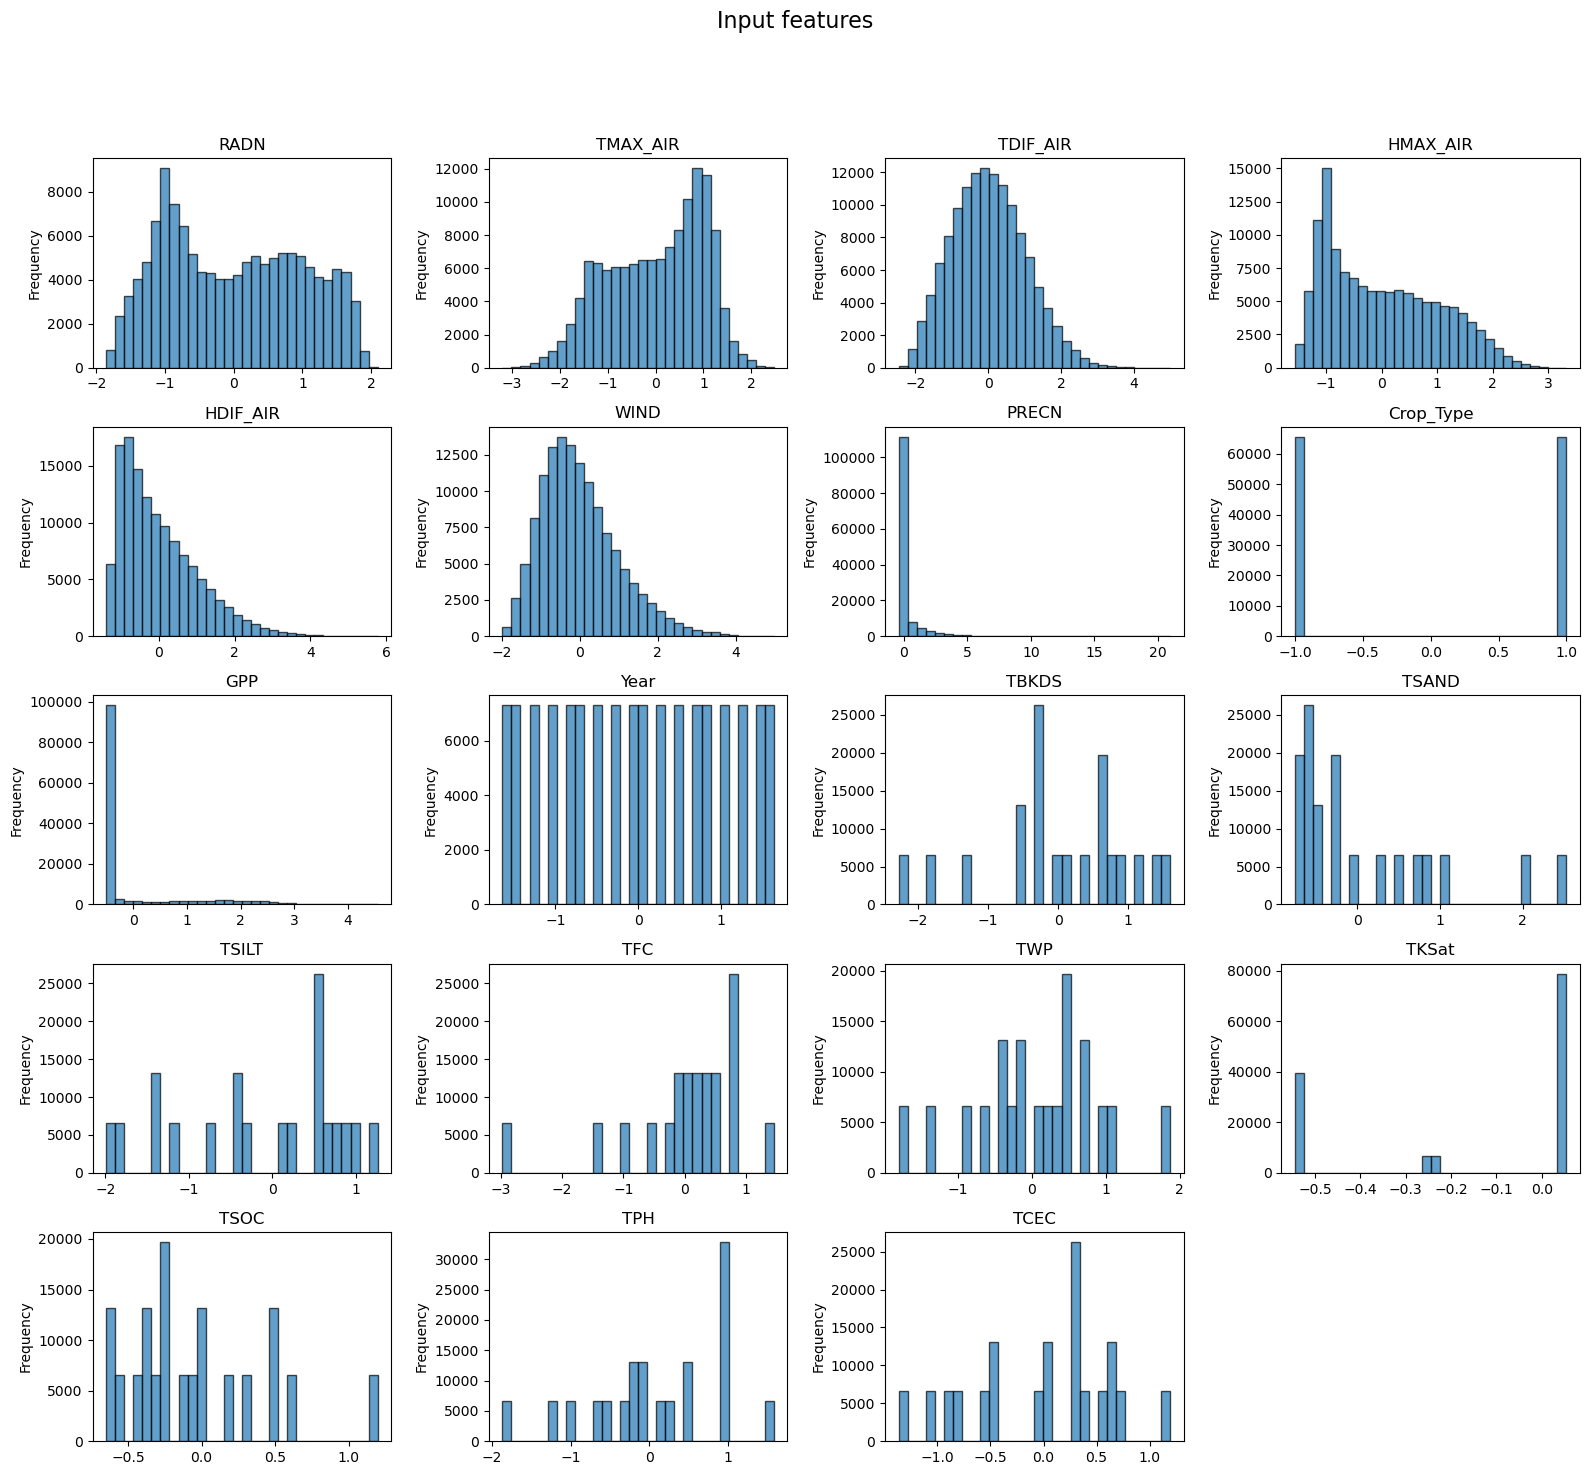

In [18]:
# View histogram of input features
feature_len = len(input_features)
features = input_features
values = X_train.reshape(-1, feature_len)
sub_title = "Input features"
plot_features(values, feature_len, features, sub_title)

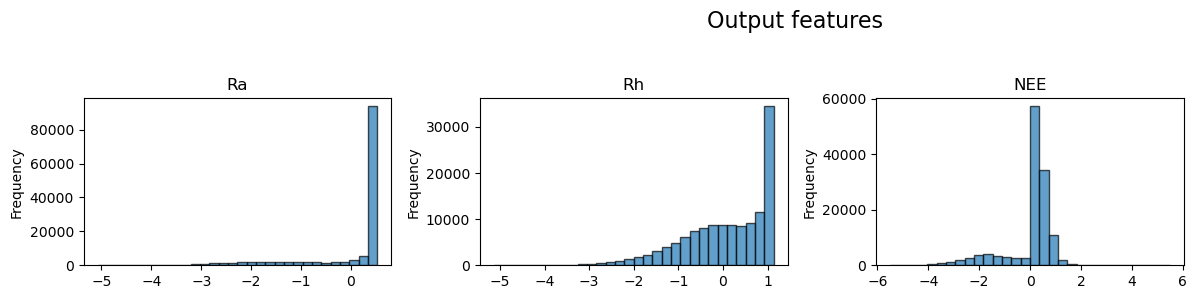

In [19]:
# View histogram of output features
feature_len = len(output_features)
features = output_features
values = Y_train.reshape(-1, feature_len)
sub_title = "Output features"
plot_features(values, feature_len, features, sub_title)

### Step 3: model selection and data preparation:  

1. Models and required parameters:
- LSTMSeq2Seq (input_dim, hidden_dim, num_layers, output_dim)   

- GRUSeq2Seq (input_dim, hidden_dim, num_layers, output_dim) 

- 1dCNN (input_dim, hidden_dim, num_layers, output_dim, dropout) 

- Attention (input_dim, hidden_dim, num_layers, output_dim) 

- GRUSeq2SeqWithAttention (input_dim, hidden_dim, num_layers, output_dim, dropout)   

- N2OGRU_KGML (input_dim, hidden_dim, num_layers, output_dim1, output_dim2, dropout) 

- RecoGRU_KGML (input_dim, hidden_dim, num_layers, output_dim, dropout) 

- TimeSeriesTransformer (input_dim, hidden_dim, num_layers, output_dim, d_model, nhead, dropout) 

<br>

2. Data preparation:
- Slice sequence data by a given length using SequenceDataset(inputs, outputs, days_per_year).   
    
    For example, an inputs of size [1 sample, 750 days, 5 features] will be converted to the size of [2, 365, 5] given days_per_year = 365. 
 
- Load data for efficient batching using DataLoader(train_dataset, batch_size=batch_size, shuffle=True).


In [20]:
# Set parameters for a selected model
input_dim = len(input_features)
hidden_dim = 128
num_layers = 3
output_dim = len(output_features)
dropout = 0.2

# Define a model 
model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [21]:
# Use 365 consecutive days as a sample
sequence_length = 365  

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create the dataLoaders for training and testing
batch_size = 64
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [22]:
# Set hyperparameters for model training
learning_rate = 0.001
step_size = 20
max_epoch = 50
gamma = 0.6

# Set a loss function. Here we select nn.L1Loss() from PyTorch.
loss_function = nn.L1Loss()
# Set the path to save model weights
checkpoint_path = output_path + 'pretrained_GRU.pth'

# train the model
model.train_model(loss_func=loss_function, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=checkpoint_path)

Epoch 1/50 | LR: 0.001000, Train Loss: 0.5944, Test Loss: 0.5135
Epoch 2/50 | LR: 0.001000, Train Loss: 0.4309, Test Loss: 0.4101
Epoch 3/50 | LR: 0.001000, Train Loss: 0.3375, Test Loss: 0.3168
Epoch 4/50 | LR: 0.001000, Train Loss: 0.2737, Test Loss: 0.2748
Epoch 5/50 | LR: 0.001000, Train Loss: 0.2403, Test Loss: 0.2557
Epoch 6/50 | LR: 0.001000, Train Loss: 0.2220, Test Loss: 0.2282
Epoch 7/50 | LR: 0.001000, Train Loss: 0.2092, Test Loss: 0.2233
Epoch 8/50 | LR: 0.001000, Train Loss: 0.1987, Test Loss: 0.2106
Epoch 9/50 | LR: 0.001000, Train Loss: 0.1905, Test Loss: 0.2048
Epoch 10/50 | LR: 0.001000, Train Loss: 0.1828, Test Loss: 0.1985
Epoch 11/50 | LR: 0.001000, Train Loss: 0.1774, Test Loss: 0.1969
Epoch 12/50 | LR: 0.001000, Train Loss: 0.1727, Test Loss: 0.1893
Epoch 13/50 | LR: 0.001000, Train Loss: 0.1663, Test Loss: 0.1888
Epoch 14/50 | LR: 0.001000, Train Loss: 0.1620, Test Loss: 0.1848
Epoch 15/50 | LR: 0.001000, Train Loss: 0.1580, Test Loss: 0.1783
Epoch 16/50 | LR: 0

In [23]:
# model testing using test_dataset
model.test()

Test Loss: 0.1688


### Visualization
Functions for visualizing the model performance incude:  
- **plot_training_curves()**: plot the loss curves of training and testing. 

- **vis_plot_prediction_result_time_series(y_scaler, output_feature_name)**: visualize the predicted sequence vs. the true values at a specific site and year.  

- **vis_scatter_prediction_result(y_scaler, output_feature_name)**: visualize the predicted values vs. true values in scatters.


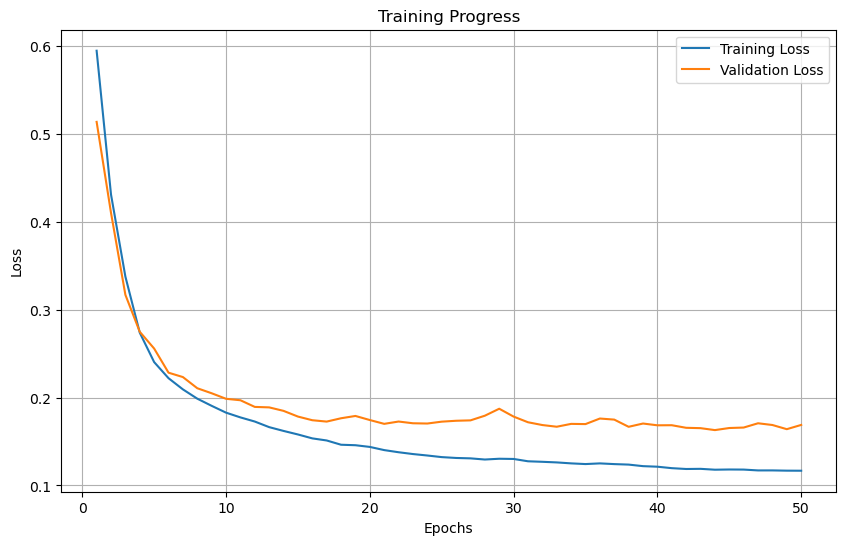

In [24]:
# Plot the learning curves
model.plot_training_curves()

In [25]:
# Calculate model's coefficient of determination
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.953637296499759
Feature Rh R2 Score is: 0.8094328496003993
Feature NEE R2 Score is: 0.9452857507427684


In [26]:
# Visualize the time series of model prediction and true value at a given site-year
model.vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)

TypeError: TimeSeriesModel.vis_plot_prediction_result_time_series() got an unexpected keyword argument 'site'

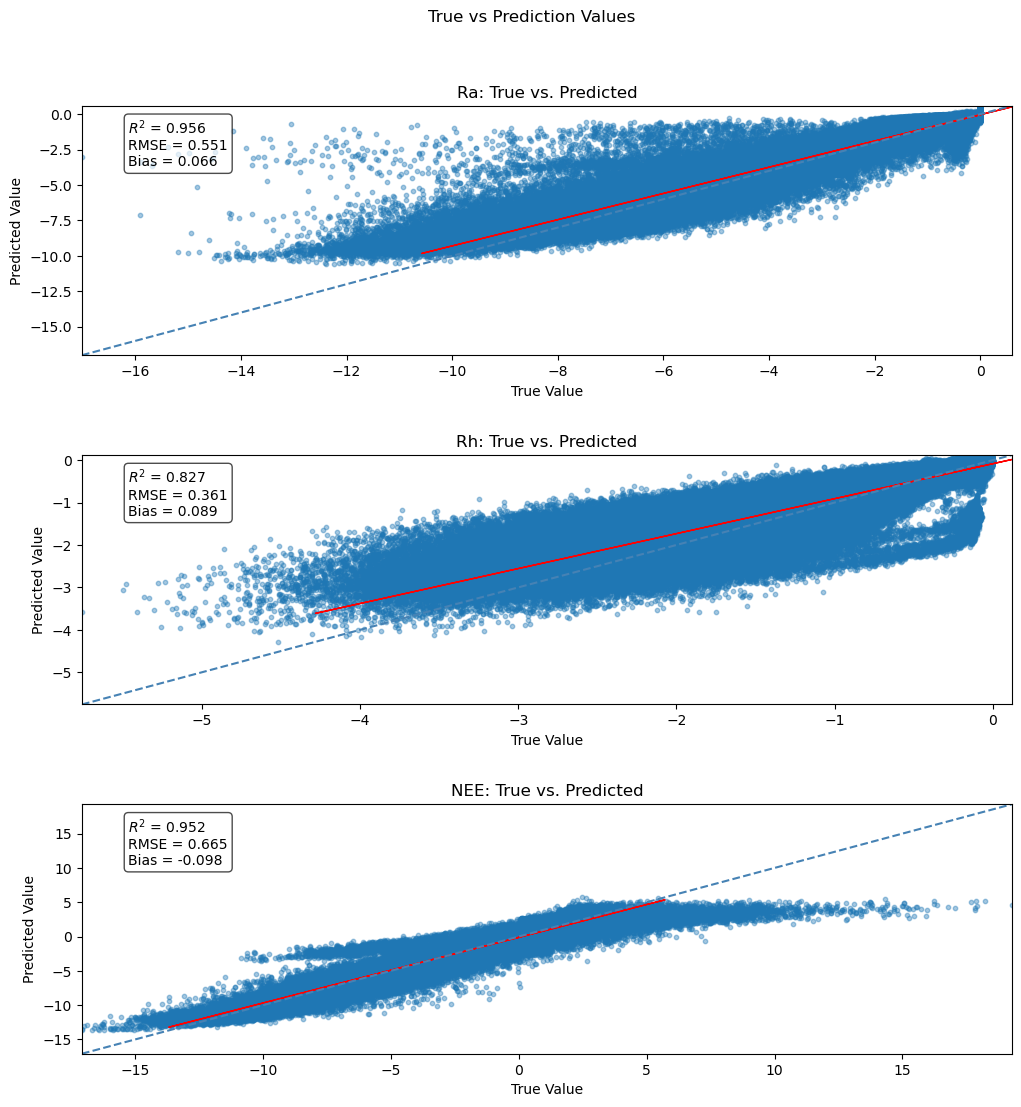

In [ ]:
# Visulize the prediction vs. true value on a scatter plot
model.vis_scatter_prediction_result(y_scaler, output_feature_name)

---
### Advanced functions

The above is the end of a simple case of using PyKGML to pretrain a model on the synthetic data.  

In the following exploration, we will demonstrate advanced functions of PyKGML, including design a model structure, customize a loss function and fine-tune a pretrained model. 

### Step 4: model structure design

We proposed a GRU-based model structure according to the relationship of the three response variables, Ra, Rh, and NEE. This model is a simplified version of the KGMLag model in [Liu's 2024 paper](https://www.nature.com/articles/s41467-023-43860-5). 

This proposed model does not nessacerily outperform the previous model, but it highlights causal relationships between the predicted variables (Ra, Rh, and NEE) with a hierarchical structure. For the structure design that can perform better than the pure ML model, please refer to Liu's original study.

<img src="./Model structure.png">

In the diagram:
* There are four GRU cells, Cell-1 (GRU-basic), Cell-2 (GRU-Ra), Cell-3 (GRU-Rh), and Cell-4 (GRU-NEE). Each cell has its own output (output1, output2, output3, and output4).  

* There are three fully connected (FC) layers for converting outputs from GRU cells to the target variables: Ra, Rh, and NEE.  

* Inside the parentheses are the input and the output of a GRU cell or FC layer. 

* Inside the square brackets are the dimension corresponding to the input and output.  

* The colored arrow indicates an output from a cell with the same color goes to another cell as an input.  


<br>

To build this model structure, we import the structure compiler from kgml_lib:
```python
        import kgml_lib  
        ModelStructureCompiler = kgml_lib.ModelStructureCompiler  
```
or 
```python
        from kgml_lib import ModelStructureCompiler
```
A configuration script need to be filled in this format:

```python
        archt_config = {
        # define name and parameters
        'class_name': str,
        'base_class': 'TimeSeriesModel',
        'init_params': {
                'input_dim': int,
                'hidden_dim': int,
                'num_layers': int,
                'output_dim': int,
                'dropout': float
        },
        # Define model components 
        'layers': {
                'layer1': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
                'layer2': ('lstm', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
                'dropout':   ('dropout', 'dropout'),
                'fc':        ('linear', 'hidden_dim', 'output_dim'),
                ...
        },
        # Define the forward function. 
        'forward': {
                ...
        }
        }
```
We will use the example of the proposed model design to explain the script.

In [ ]:
# Import the help compiler for model structure design
ModelStructureCompiler = kgml_lib.ModelStructureCompiler

# Fill a configuration script to describe the proposed model structure
archt_config = {
    # define name and parameters
    'class_name': 'my_KGML',
    'base_class': 'TimeSeriesModel',
    'init_params': {
        'input_dim': 19,
        'hidden_dim': 128,
        'num_layers': 2,
        'output_dim': 3,
        'dropout': 0.2
    },
    # Define model components, where the key is a given name for a layer and the value is tuple of layer parameters. 
    # The first parameter is the layer name, which can be 'gru' for torch.nn.GRU or 'lstm' for torch.nn.LSTM.
    # The rest of the parameters in the tuple are parameters feed to the layer. 
    'layers': {
            'gru_basic': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_ra':    ('gru', 'input_dim + hidden_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_rh':    ('gru', 'input_dim + hidden_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_nee':   ('gru', 'input_dim+2', 'hidden_dim', 'num_layers', 'dropout'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
    },
    # Define the forward function. This is where layers are connected to each other with inputs and outputs.
    'forward': {
        'out_basic, hidden': 'gru_basic(x)',
        'dropped':   'dropout(out_basic)',
        'ra_in':     'x & dropped',
        'ra_out, hidden':    'gru_ra(ra_in)',
        'ra_pred':   'fc(dropout(ra_out))',
        'rh_in':     'x & dropped',
        'rh_out, hidden':    'gru_rh(rh_in)',
        'rh_pred':   'fc(dropout(rh_out))',
        'nee_in':    'x & ra_pred & rh_pred',
        'nee_out, hidden':   'gru_nee(nee_in)',
        'nee_pred':  'fc(dropout(nee_out))',
        'output':    'ra_pred & rh_pred & nee_pred'
    }
}


In [ ]:
# Feed the config to the pre-defined compiler. 
archt_compiler = ModelStructureCompiler(archt_config)

# Call generate_model() on the compiler to generate a model class.
KGML = archt_compiler.generate_model()

# Call class_code on the compiler to show the generated model structure.
print("Generated class code:")
print(archt_compiler.class_code)

Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.gru_basic = nn.GRU(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_ra = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_rh = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_nee = nn.GRU(input_dim+2, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.T

In [ ]:
# Define a model using the compiled architecture
myKGML1 = KGML()
# Create dataLoaders for the model
batch_size = 64
myKGML1.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
myKGML1.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Set up hyperparameters
learning_rate = 0.001
step_size = 20
max_epoch = 1
gamma = 0.6
loss_function = nn.L1Loss() # nn.MSELoss()
checkpoint_path = output_path + 'customArcht_GRU.pth'

# Train the model
myKGML1.train_model(loss_func=loss_function, LR=learning_rate, step_size= step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=checkpoint_path)

Epoch 1/1 | LR: 0.001000, Train Loss: 0.5520, Test Loss: 0.4622


Test Loss: 0.1763


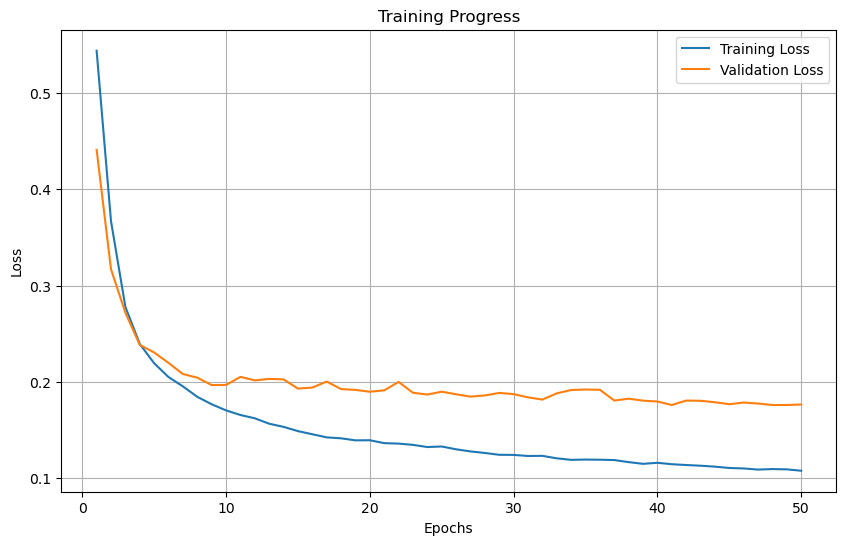

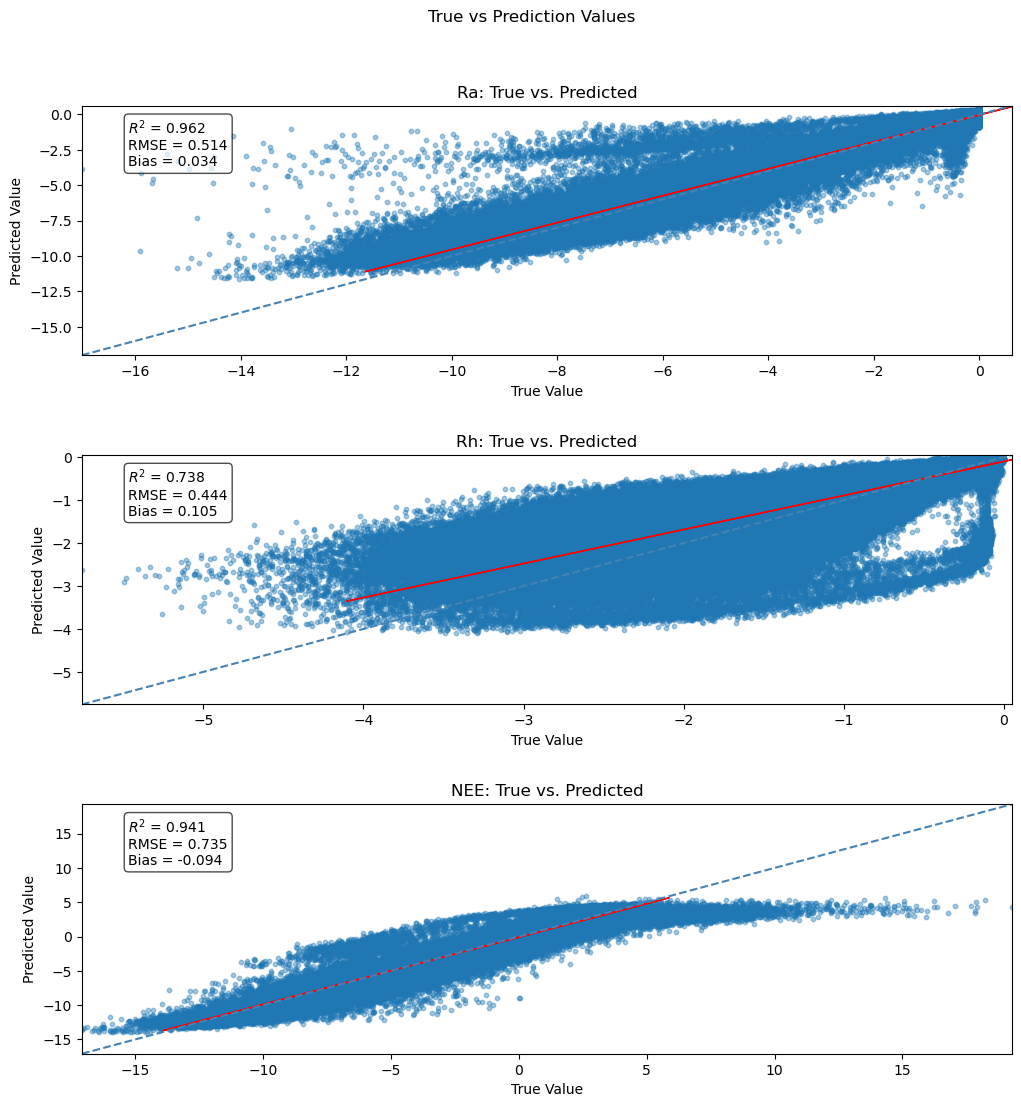

In [ ]:
# Testing the model
myKGML1.test()

# visualization
myKGML1.plot_training_curves()

output_feature_name = ['Ra','Rh','NEE']
myKGML1.vis_scatter_prediction_result(y_scaler, output_feature_name)

### Step 5: loss function customization

**Mass balance as a physical constraint**   

In step 3, we pretrained a model to predict daily Ra, Rh, and NEE. The following relationships exist for Ra, Rh, NEE and an input feature GPP:  
<pre>  
                1. Ecosystem respiration: Reco = Ra + Rh  
                
                2. Mass balance: NEE = GPP - Reco
                 
</pre>

In addition to predicting Ra, Rh, and NEE, we want to constrain the predicted values so that the mass balance is possibly maintained. Therefore, we customize a loss function that contain the residual of equation 2 to reflect the mass balance constraint.
<pre>   
            loss1 = mean[MSE(Ra, pred_Ra) + MSE(Rh, pred_Rh) + MSE(NEE, pred_NEE)]

            loss2 = mean[abs(GPP - pred_Reco - pred_NEE)] - tol_MB * abs(pred_Reco)
            
            loss = loss1 + loss2
</pre>   
Loss1 is the mean sqaure errors of predictions and true values. Loss2 is residual of the mass balance substracted by a scaler of pred_Reco, added as a panelty in the total loss. Loss 2 allows the residual of the mass balance to be larger when pred_Reco is larger.


In [ ]:
# Import the help compiler
LossFunctionCompiler = kgml_lib.LossFunctionCompiler

# GPP is the No. 9 feature in the inputs X
GPP_scaler = x_scaler[8]
# configure a script for building a loss function
lossfn_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 2,
        'tol_MB': 0.01,
        'aaa_scaler': x_scaler,
        'ccc_scaler':y_scaler},
    # Explicitly define each term that will be used in the loss function.
    # Because X and Y had been normalized, terms in the mass balance need to be reversed.
    'variables': {
        'Ra_pred': 'y_pred[:, :, Ra_idx]',
        'Rh_pred': 'y_pred[:, :, Rh_idx]',
        'NEE_pred': 'y_pred[:, :, NEE_idx]',
        'GPP_reverse': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler[GPP_idx])',
        'Ra_pred_reverse': 'Z_norm_reverse(y_pred[:, :, Ra_idx], ccc_scaler[Ra_idx])',
        'Rh_pred_reverse': 'Z_norm_reverse(y_pred[:, :, Rh_idx], ccc_scaler[Rh_idx])',
        'NEE_pred_reverse': 'Z_norm_reverse(y_pred[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        'Ra_true': 'y_true[:, :, Ra_idx]',
        'Rh_true': 'y_true[:, :, Rh_idx]',
        'NEE_true': 'y_true[:, :, NEE_idx]',
        },
        # Define the loss function.
    'loss_fomula': {
        'Reco_pred_reverse': 'Ra_pred_reverse + Rh_pred_reverse',
        'loss1': 'mean((Ra_pred - Ra_true)**2 + (Rh_pred - Rh_true)**2 + (NEE_pred - NEE_true)**2)',
        'loss2': 'mean(relu(abs(GPP_reverse + Reco_pred_reverse + NEE_pred_reverse)  - tol_MB * abs(Reco_pred_reverse)))',
        'loss': 'loss1 + loss2',}
    }

In [ ]:
# Create the compiler
lossfn_compiler = LossFunctionCompiler(lossfn_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(lossfn_compiler.class_code)

# Create the loss class
customLoss = lossfn_compiler.generate_class()
loss_fn = customLoss()

Generated CarbonFluxLoss:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_idx=0, Rh_idx=1, NEE_idx=2, tol_MB=0.01, aaa_scaler=[[15.053108964474006, 7.326538061301864], [17.193964650486368, 12.213991763373388], [9.976644474999615, 3.920628242251278], [1.4331655554728224, 0.8649237300133734], [0.42117767163499437, 0.2976678281986924], [373.3158668814395, 144.32230851758112], [2.8037624222923756, 7.2096132460220135], [3.000774068698597, 1.9999998502044234], [2.8892129010294383, 5.757924175519595], [2009.500244140625, 5.1881279945373535], [1.3850725548995193, 0.10334471059856785], [165.73811764894734, 179.75278592057546], [591.1589363146128, 161.2505438232744], [0.2988145731775208, 0.04200548586636309], [0.16535801808608863, 0.04892610339609015], [30.943542166741274, 38.18836355218684], [17.082202355828215, 19.632706474926852], [6.237856846289411, 0.4814664318210326], [20.170418101874997, 8.91454300038102]], ccc_scaler=[[-1.35840237

In [ ]:
# We will create a model the same as the model in step 3 to use the loss function
myKGML2 = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

# Load the model weights from the training of the previous model
checkpoint_path = output_path + 'pretrained_GRU.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)
myKGML2.load_pretrained(pretrained_model_path=checkpoint_path)

# Create DataLoaders
myKGML2.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
myKGML2.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

GRUSeq2SeqWithAttention(
  (gru): GRU(19, 128, num_layers=3, batch_first=True)
  (attention): Attention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model's state_dict:
gru.weight_ih_l0 	 torch.Size([384, 19])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
gru.weight_ih_l1 	 torch.Size([384, 128])
gru.weight_hh_l1 	 torch.Size([384, 128])
gru.bias_ih_l1 	 torch.Size([384])
gru.bias_hh_l1 	 torch.Size([384])
gru.weight_ih_l2 	 torch.Size([384, 128])
gru.weight_hh_l2 	 torch.Size([384, 128])
gru.bias_ih_l2 	 torch.Size([384])
gru.bias_hh_l2 	 torch.Size([384])
attention.query.weight 	 torch.Size([128, 128])
attention.query.bias 	 torch.Size([128])
attention.key.weight 

The model parameters and hyperparameters for training are the same as in the step 3, except that the loss function should be the customzed "loss_fn".

In [ ]:
batch_size = 64
learning_rate = 0.001
step_size = 20
max_epoch = 50
gamma = 0.6

new_checkpoint_path = output_path + 'customLoss_GRU.pth'
# Train the model with the customzed loss function
myKGML2.train_model(loss_func=loss_fn, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=new_checkpoint_path)


Epoch 1/50 | LR: 0.001000, Train Loss: 1.0269, Test Loss: 0.8013
Epoch 2/50 | LR: 0.001000, Train Loss: 0.5732, Test Loss: 0.6056
Epoch 3/50 | LR: 0.001000, Train Loss: 0.4459, Test Loss: 0.4531
Epoch 4/50 | LR: 0.001000, Train Loss: 0.3831, Test Loss: 0.4724
Epoch 5/50 | LR: 0.001000, Train Loss: 0.3461, Test Loss: 0.4164
Epoch 6/50 | LR: 0.001000, Train Loss: 0.3425, Test Loss: 0.4068
Epoch 7/50 | LR: 0.001000, Train Loss: 0.3213, Test Loss: 0.4484
Epoch 8/50 | LR: 0.001000, Train Loss: 0.3320, Test Loss: 0.4304
Epoch 9/50 | LR: 0.001000, Train Loss: 0.3333, Test Loss: 0.4494
Epoch 10/50 | LR: 0.001000, Train Loss: 0.3188, Test Loss: 0.4370
Epoch 11/50 | LR: 0.001000, Train Loss: 0.3149, Test Loss: 0.4766
Epoch 12/50 | LR: 0.001000, Train Loss: 0.3048, Test Loss: 0.4071
Epoch 13/50 | LR: 0.001000, Train Loss: 0.3110, Test Loss: 0.4037
Epoch 14/50 | LR: 0.001000, Train Loss: 0.3021, Test Loss: 0.4132
Epoch 15/50 | LR: 0.001000, Train Loss: 0.2999, Test Loss: 0.4356
Epoch 16/50 | LR: 0

/Users/yufengyang/Documents/GitHub/PyKGML_development/time_series_models.py:439: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(checkpoint_pat

Test Loss: 0.3991


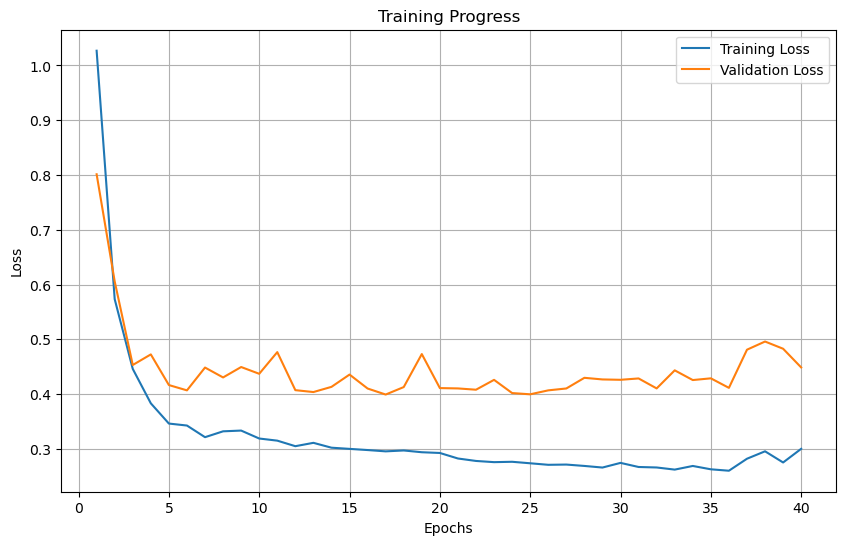

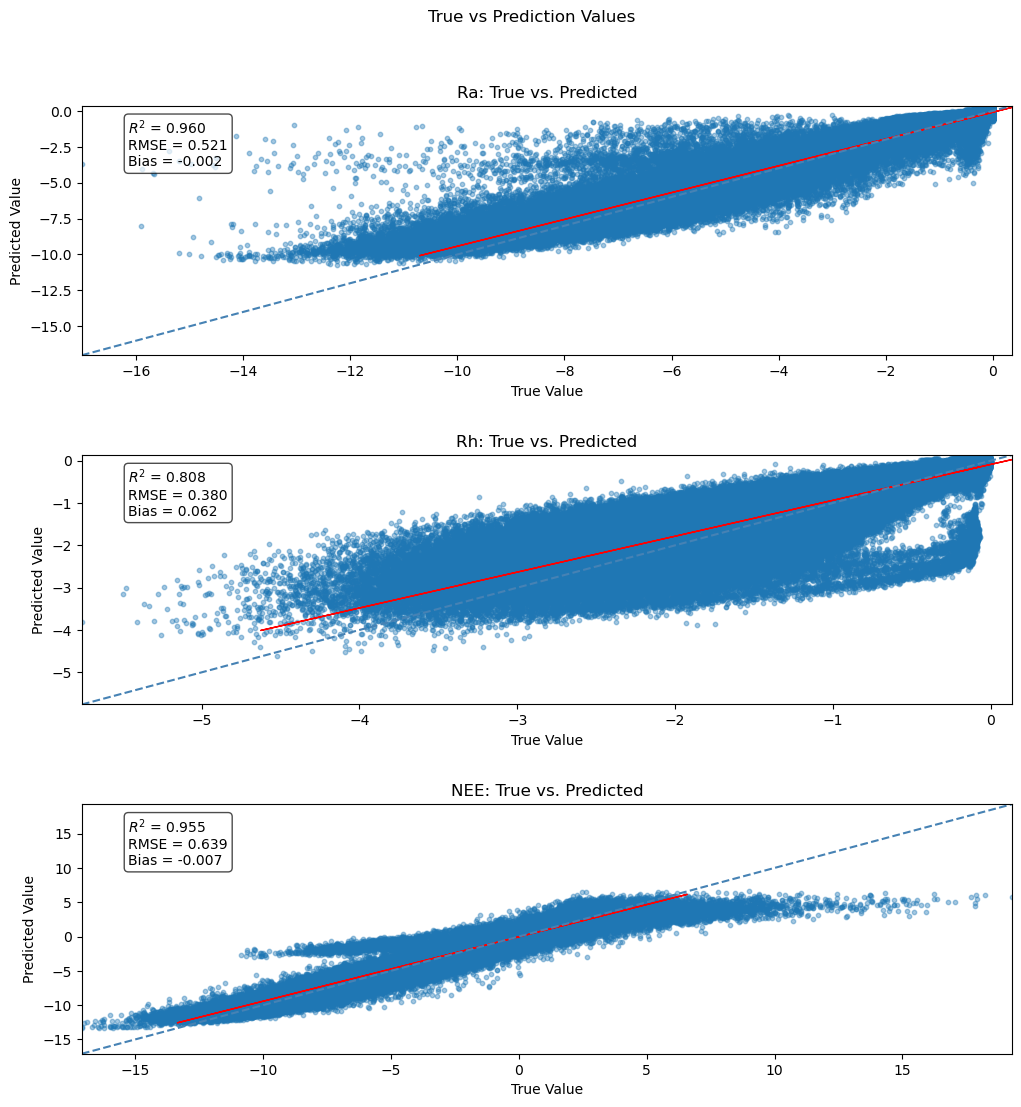

In [ ]:
# Test the model
myKGML2.test()

# Visualize the learning curves
myKGML2.plot_training_curves()

# Visualize a scatter plot
output_feature_name = ['Ra','Rh','NEE']
myKGML2.vis_scatter_prediction_result(y_scaler, output_feature_name)

### Step 6: fine tune a pretrained model

Fine-tuning a model using real observations can adjust the model to be more adaptive to the observed conditions. To do so, weights of the pretrained model will be used as its the initial weights during the fine-tuning.

In the example fine-tuning dataset we provided (co2_finetune_data), there are only two output variables: Reco and NEE, because Ra and Rh do not exist in the real observations. We need to modify the loss function as the follows so that Reco can be compared with the sum of predicted Ra and predicted Rh. 
<pre>   
            loss = mean[MSE(Reco, pred_Ra + pred_Rh) + MSE(NEE, pred_NEE)]

</pre>   
Important notes about the fine-tuning dataset:
1. Reco and NEE (in Y_train and Y_test) are not standardized, and should be compared with reversed values of the corresponding model prediction. 

2. Reco values are positive, not negative as in the synthetic data.

In [ ]:
# Assign training and testing data. 
X_train_ft, X_test_ft, Y_train_ft, Y_test_ft = finetune_data['X_train'], finetune_data['X_test'], finetune_data['Y_train'], finetune_data['Y_test']
x_scaler_ft = finetune_data['x_scaler']
input_features_ft = finetune_data['input_features']
output_features_ft = finetune_data['output_features']

print(X_train_ft.shape, Y_train_ft.shape, X_test_ft.shape, Y_test_ft.shape)
print(input_features_ft,output_features_ft)

torch.Size([1, 37230, 19]) torch.Size([1, 37230, 2]) torch.Size([1, 8030, 19]) torch.Size([1, 8030, 2])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC'] ['NEE', 'RECO']


In [ ]:
# configure a script to customize a loss function for fune-tuning

ft_lossfn_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_pred_idx': 0,
        'Rh_pred_idx': 1,
        'NEE_pred_idx': 2,
        'NEE_true_idx': 0,
        'Reco_true_idx': 1,
        'aaa_scaler': x_scaler,
        'bbb_scaler': y_scaler},
    # revise this part to remove scaler and z_norm_reverse. 1. scaling methods (pre-define) 2. scaler
    'variables': {
        'Ra_pred': 'y_pred[:, :, Ra_pred_idx]',
        'Rh_pred': 'y_pred[:, :, Rh_pred_idx]',
        'NEE_pred': 'y_pred[:, :, NEE_pred_idx]',
        'NEE_true': 'y_true[:, :, NEE_true_idx]',
        'Reco_true': 'y_true[:, :, Reco_true_idx]',
        'GPP_reverse': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler[GPP_idx])',
        'Ra_pred_reverse': '-Z_norm_reverse(y_pred[:, :, Ra_pred_idx], bbb_scaler[Ra_pred_idx])',
        'Rh_pred_reverse': '-Z_norm_reverse(y_pred[:, :, Rh_pred_idx], bbb_scaler[Rh_pred_idx])',
        'NEE_pred_reverse': 'Z_norm_reverse(y_pred[:, :, NEE_pred_idx], bbb_scaler[NEE_pred_idx])',
        },
    
    'loss_fomula': {
        'Reco_pred_reverse': 'Ra_pred_reverse + Rh_pred_reverse',
        'loss': 'mean((NEE_pred_reverse - NEE_true)**2 + (Reco_pred_reverse - Reco_true)**2)',
        }
    }

In [ ]:
# Create the compiler
ft_lossfn_compiler = LossFunctionCompiler(ft_lossfn_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(ft_lossfn_compiler.class_code)

# Create the loss class
ft_customLoss = ft_lossfn_compiler.generate_class()
ft_loss_fn = ft_customLoss()

Generated CarbonFluxLoss:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_pred_idx=0, Rh_pred_idx=1, NEE_pred_idx=2, NEE_true_idx=0, Reco_true_idx=1, aaa_scaler=[[15.053108964474006, 7.326538061301864], [17.193964650486368, 12.213991763373388], [9.976644474999615, 3.920628242251278], [1.4331655554728224, 0.8649237300133734], [0.42117767163499437, 0.2976678281986924], [373.3158668814395, 144.32230851758112], [2.8037624222923756, 7.2096132460220135], [3.000774068698597, 1.9999998502044234], [2.8892129010294383, 5.757924175519595], [2009.500244140625, 5.1881279945373535], [1.3850725548995193, 0.10334471059856785], [165.73811764894734, 179.75278592057546], [591.1589363146128, 161.2505438232744], [0.2988145731775208, 0.04200548586636309], [0.16535801808608863, 0.04892610339609015], [30.943542166741274, 38.18836355218684], [17.082202355828215, 19.632706474926852], [6.237856846289411, 0.4814664318210326], [20.170418101874997, 8.9145430

In [ ]:
# Define hyperparameters
ft_input_dim = len(input_features)
hidden_dim = 128
num_layers = 3
ft_output_dim = len(output_features)
dropout=0.2

# Locate the weight file saved during the pretraining 
checkpoint_path = output_path + 'pretrained_GRU.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)

# Define the fine-tuning model parameters, which be the same as the pretrained model
# KGML_ft = KGML(input_dim, hidden_dim, num_layers, ft_output_dim, dropout)
KGML_ft = GRUSeq2SeqWithAttention(ft_input_dim, hidden_dim, num_layers, ft_output_dim, dropout)
# reload model weights
KGML_ft.load_pretrained(pretrained_model_path=checkpoint_path)

GRUSeq2SeqWithAttention(
  (gru): GRU(19, 128, num_layers=3, batch_first=True)
  (attention): Attention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Model's state_dict:
gru.weight_ih_l0 	 torch.Size([384, 19])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
gru.weight_ih_l1 	 torch.Size([384, 128])
gru.weight_hh_l1 	 torch.Size([384, 128])
gru.bias_ih_l1 	 torch.Size([384])
gru.bias_hh_l1 	 torch.Size([384])
gru.weight_ih_l2 	 torch.Size([384, 128])
gru.weight_hh_l2 	 torch.Size([384, 128])
gru.bias_ih_l2 	 torch.Size([384])
gru.bias_hh_l2 	 torch.Size([384])
attention.query.weight 	 torch.Size([128, 128])
attention.query.bias 	 torch.Size([128])
attention.key.weight 

In [ ]:
# Use 365 consecutive days as a sample
sequence_length = 365

# Create Dataset objects for training and testing.
train_dataset_ft = SequenceDataset(X_train_ft, Y_train_ft, sequence_length)
test_dataset_ft = SequenceDataset(X_test_ft, Y_test_ft, sequence_length)

# Create DataLoaders.
batch_size = 64
KGML_ft.train_loader = DataLoader(train_dataset_ft, batch_size=batch_size, shuffle=True)
KGML_ft.test_loader  = DataLoader(test_dataset_ft, batch_size=1, shuffle=False)

In [ ]:
learning_rate = 0.001
step_size = 20
max_epoch = 100
gamma = 0.8

ft_checkpoint_path = output_path + 'finetune_GRU.pth'
# Train the model
KGML_ft.train_model(loss_func=ft_loss_fn, LR=learning_rate, step_size=step_size, gamma=gamma, maxepoch=max_epoch, checkpoint_path=ft_checkpoint_path)

Epoch 1/100 | LR: 0.001000, Train Loss: 2.9200, Test Loss: 2.6616
Epoch 2/100 | LR: 0.001000, Train Loss: 2.4735, Test Loss: 2.2898
Epoch 3/100 | LR: 0.001000, Train Loss: 2.2455, Test Loss: 2.0889
Epoch 4/100 | LR: 0.001000, Train Loss: 2.0394, Test Loss: 1.9798
Epoch 5/100 | LR: 0.001000, Train Loss: 1.9747, Test Loss: 2.0205
Epoch 6/100 | LR: 0.001000, Train Loss: 1.8178, Test Loss: 1.8965
Epoch 7/100 | LR: 0.001000, Train Loss: 1.8964, Test Loss: 1.7765
Epoch 8/100 | LR: 0.001000, Train Loss: 1.7134, Test Loss: 1.7375
Epoch 9/100 | LR: 0.001000, Train Loss: 1.7547, Test Loss: 1.8534
Epoch 10/100 | LR: 0.001000, Train Loss: 1.7080, Test Loss: 1.8702
Epoch 11/100 | LR: 0.001000, Train Loss: 1.6745, Test Loss: 1.8106
Epoch 12/100 | LR: 0.001000, Train Loss: 1.6428, Test Loss: 1.7646
Epoch 13/100 | LR: 0.001000, Train Loss: 1.5993, Test Loss: 1.7450
Epoch 14/100 | LR: 0.001000, Train Loss: 1.5297, Test Loss: 1.6961
Epoch 15/100 | LR: 0.001000, Train Loss: 1.4777, Test Loss: 1.6653
Epoc

**Visualization**   

Due to the mismatch in the outputs of the pretrained model ([Ra, Rh, NEE]) and the fine-tune dataset ([NEE, Reco]), we need to reconstruct the prediction and true value for some functions that use both, such as get_R2_score() and Vis_scatter_prediction_result().

Test Loss: 1.3203


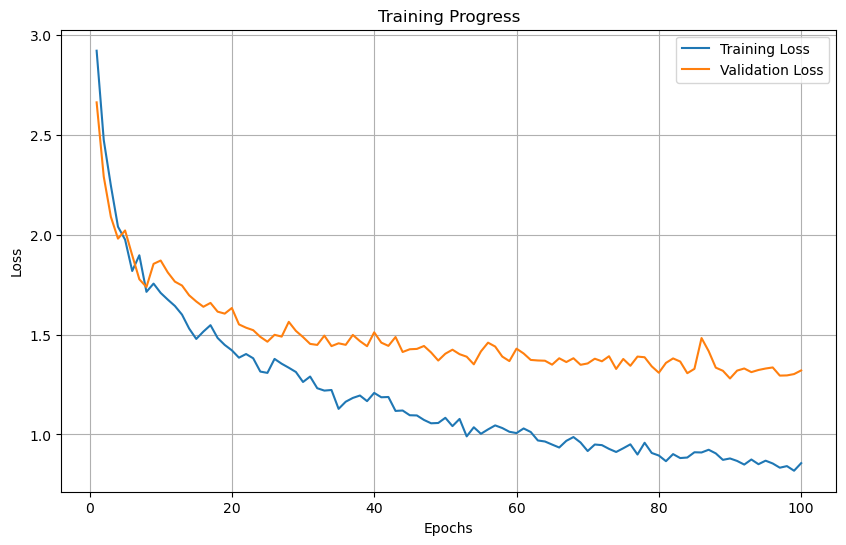

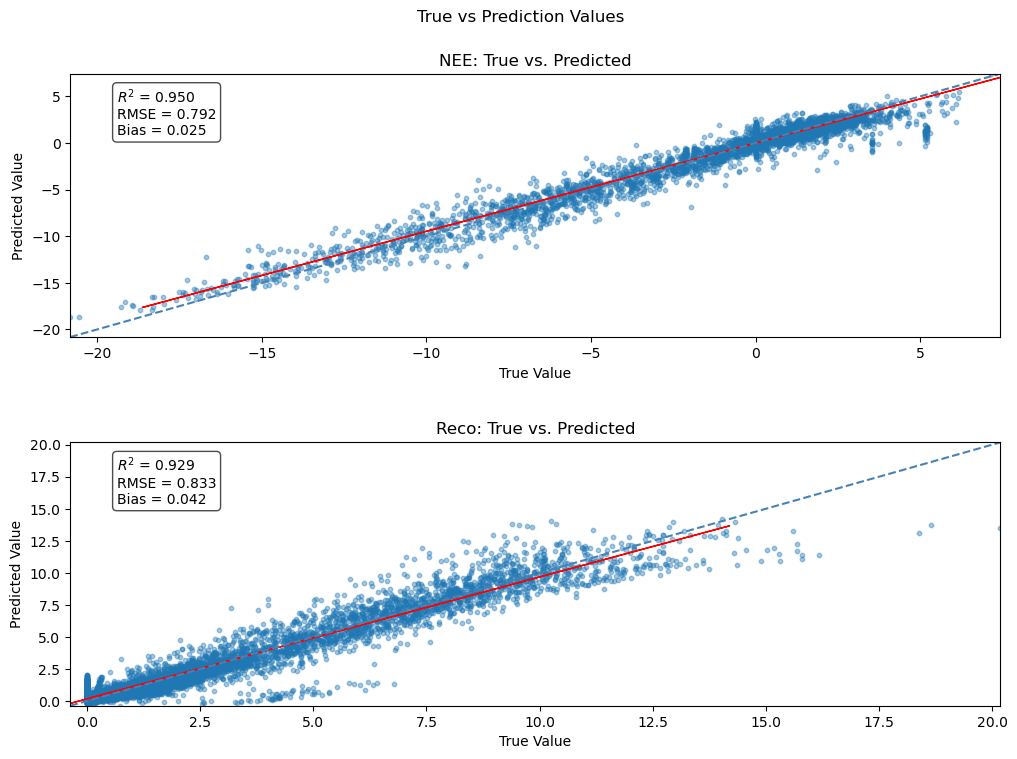

In [ ]:
# Import functions for calculating R2 and visualizing results
from kgml_lib import get_R2_score, vis_scatter_prediction_result, Z_norm_reverse
KGML_ft.test()
# Visualize the learning curves
KGML_ft.plot_training_curves()

# Construct a prediction that contains [NEE, Reco] from the direct model outputs of [Ra, Rh, NEE]
ft_Ra_pred = Z_norm_reverse(KGML_ft.all_predictions[:,:,0], y_scaler[0])
ft_Rh_pred = Z_norm_reverse(KGML_ft.all_predictions[:,:,1], y_scaler[1])
ft_NEE_pred = Z_norm_reverse(KGML_ft.all_predictions[:,:,2], y_scaler[2])
ft_predictions = torch.stack([ft_NEE_pred, -(ft_Ra_pred + ft_Rh_pred)], dim=2)
ft_targets = KGML_ft.all_targets

# The predictions have been reversed using the y_scaler.
y_scaler_ft = None
output_feature_name = ['NEE', 'Reco']
vis_scatter_prediction_result(target=ft_targets, prediction=ft_predictions, y_scaler=y_scaler_ft, features=output_feature_name)